In [ ]:
import torchvision.transforms as tfs
from src.models.utils import download_checkpoint, load_model
from src.experiments import *
from src.experiments.utils import *
from src.visualization import *
from src.optimization import *
from IPython.display import Image 
from PIL import Image
from src.optimization.transforms import BilateralFilter

checkpoint_path = download_checkpoint("https://drive.google.com/file/d/19m_SaRNEF7JXHjeyNu26AxgaEQXqpI00", "protopnet.pt")
model = load_model('protopnet', checkpoint_path, device="cuda")
img_size = 224

# crop all training images from given class using bounding boxes and save to data/train_cropped/
# crop_images("189.Red_bellied_Woodpecker") 

Installing bilateral-filter...
  Cloning git://github.com/adriansuwala/bilateral-filter.git (to revision main) to /tmp/pip-req-build-l8fq1l6w



# Comparison with gaussian blur

Gaussian blur:
step: 0/300, loss: 10.55843448638916
step: 100/300, loss: 0.0845990851521492
step: 200/300, loss: 0.21482381224632263


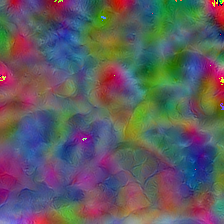

Bilateral filter:
step: 0/300, loss: 10.55843448638916
step: 100/300, loss: 0.15341466665267944
step: 200/300, loss: 0.10943479090929031


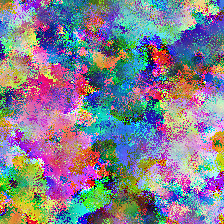

In [ ]:
ptypes = [(188,1)]
size = (3, 224, 224)

def before_optim_step(t):
    tt = torch.clamp(t, 0, 1)
    t.data = BilateralFilter(7, 0.2, 16)(t.unsqueeze(0))[0].squeeze(0)

def before_optim_step2(t):
    tt = torch.clamp(t, 0, 1)
    t.data = tfs.GaussianBlur(7, 2)(tt).data

base_tensor = torch.randn(size)

print('Gaussian blur:')
input_tensor = base_tensor.clone().cuda()
image_gb = visualize_prototypes(model, ptypes, optimization_steps=300, input_tensor=input_tensor,
                             before_optim_step=before_optim_step2, optimizer_kwargs={'lr': 0.2},
                             display_interval=None)
pilimg_gb = tfs.ToPILImage()(image_gb)
display(pilimg_gb)

print('Bilateral filter:')
input_tensor = base_tensor.clone().cuda()
image_bf = visualize_prototypes(model, ptypes, optimization_steps=300, input_tensor=input_tensor,
                             before_optim_step=before_optim_step, optimizer_kwargs={'lr': 0.2},
                             display_interval=None)
pilimg_bf = tfs.ToPILImage()(image_bf)
display(pilimg_bf)

# simple run

step: 0/300, loss: 10.404376029968262


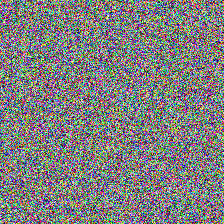

step: 100/300, loss: 0.26447248458862305
step: 200/300, loss: 0.07023776322603226


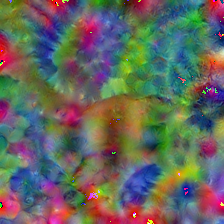

In [ ]:
ptypes = [(188,1)]
size = (3, 224, 224)

def before_optim_step(t):
    t.data = torch.clamp(t, 0, 1)
    t.data = BilateralFilter(5, 16, 1)(t)

input_tensor = torch.randn(size).cuda()
image = visualize_prototypes(model, ptypes, optimization_steps=300, input_tensor=input_tensor,
                             before_optim_step=before_optim_step, optimizer_kwargs={'lr': 0.2})
pilimg = tfs.ToPILImage()(image)
display(pilimg)

# Parameter search

0.2 16
step: 0/300, loss: 10.618372917175293
step: 100/300, loss: 0.12034045904874802
step: 200/300, loss: 0.04434048384428024


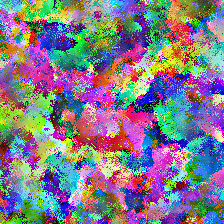

16 0.2
step: 0/300, loss: 10.618372917175293
step: 100/300, loss: 0.02401484176516533
step: 200/300, loss: 0.013303172774612904


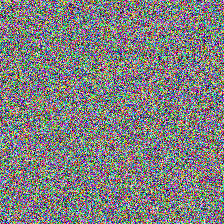

16 0.5
step: 0/300, loss: 10.618372917175293
step: 100/300, loss: 0.3473781645298004
step: 200/300, loss: 0.2249699831008911


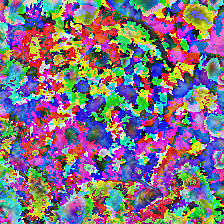

10 0.5
step: 0/300, loss: 10.618372917175293
step: 100/300, loss: 0.044953636825084686
step: 200/300, loss: 0.07579819113016129


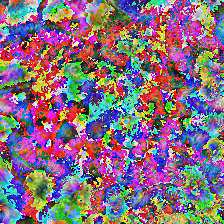

In [ ]:
ptypes = [(188,1)]
size = (3, 224, 224)

def get_before_optim_step(k, v, s):
    def before_optim_step(t):
        tt = torch.clamp(t, 0, 1)
        # t.data = bilateral_cuda.forward(tt.unsqueeze(0), 5, sigma_v, sigma_s)[0].squeeze(0)
        t.data = BilateralFilter(k, v, s)(t.unsqueeze(0))[0].squeeze(0)
    return before_optim_step

base_tensor = torch.randn(size).cuda()

images = {}
for v,s in [(0.2, 16), (16, 0.2), (16, 0.5), (10, 0.5)]:
    print(v, s)
    f = get_before_optim_step(5, v, s)    
    input_tensor = base_tensor.clone()
    image_bf = visualize_prototypes(model, ptypes, optimization_steps=300, input_tensor=input_tensor,
                                before_optim_step=f, optimizer_kwargs={'lr': 0.2},
                                display_interval=None)
    pilimg_bf = tfs.ToPILImage()(image_bf)
    display(pilimg_bf)
    images[(v,s)] = image_bf